In [1]:
import pandas as pd
import numpy as np

PATH = '/home/kai/data/kaggle/homecredit/'
train = pd.read_csv(PATH + 'application_train.csv')
print('train')
test = pd.read_csv(PATH + 'application_test.csv')
print('test')
# bureau = pd.read_csv(PATH + 'bureau.csv')
# print('bureau')
# bureau_balance = pd.read_csv(PATH + 'bureau_balance.csv')
# print('bureau_balance')
installments_payments = pd.read_csv(PATH + 'installments_payments.csv')
print('installments_payments done')
credit_card_balance = pd.read_csv(PATH + 'credit_card_balance.csv')
print('credit_card_balance')
POS_CASH_balance = pd.read_csv(PATH + 'POS_CASH_balance.csv')
print('POS_CASH_balance')
credit_card_balance = pd.read_csv(PATH + 'credit_card_balance.csv')
print('credit_card_balance')
previous_application = pd.read_csv(PATH + 'previous_application.csv')
print('previous_application')

train
test
installments_payments done
credit_card_balance
POS_CASH_balance
credit_card_balance
previous_application


In [2]:
import pandas as pd
import os
import gc
import numpy as np

def ratio_name(numerator, denominator): return numerator + '_' + denominator + '_ratio'

def ratio(df, numerator, denominator):
    return df[numerator] / df[denominator]

def substraction_name(col1, col2): return col1 + '_minus_' + col2

def substraction(df, col1,col2):
    return df[col1] - df[col2]



# Installments: substraction and ratio and late days

In [3]:
installments_payments.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT'], dtype=object)

In [4]:
installments_payments[substraction_name('DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT')] =\
substraction(installments_payments, 'DAYS_INSTALMENT' ,'DAYS_ENTRY_PAYMENT')

installments_payments[substraction_name('AMT_PAYMENT', 'AMT_INSTALMENT')] = \
substraction(installments_payments, 'AMT_PAYMENT' ,'AMT_INSTALMENT')

installments_payments[ratio_name('AMT_PAYMENT', 'AMT_INSTALMENT')] = \
ratio(installments_payments, 'AMT_PAYMENT' ,'AMT_INSTALMENT')

installments_payments['late_days'] = 0
x = installments_payments['DAYS_INSTALMENT_minus_DAYS_ENTRY_PAYMENT'] < 0
installments_payments['late_days'][x] = installments_payments['DAYS_INSTALMENT_minus_DAYS_ENTRY_PAYMENT'][x]

/home/kai/anaconda3/envs/tf_newer/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Numerical Columns:

In [5]:
def numerical_agg(df, gp_col, agg_col, df_name, extrafunc_list = None):
    
    agg_list = ['max', 'min', 'std','mean']
    '''
    Possible extrafunc_list: ['sum','median','two_minus_one_third','positive_count', 'negative_count','standard_error', 'trimmed_mean_10_pct', 'trimmed_mean_25_pct','normed_std', 'max_minus_min','one_third','two_third']
    '''
    if extrafunc_list:
        if 'one_third' in extrafunc_list:
            def one_third(series):
                return series.quantile(1/3)
            
        if 'two_third' in extrafunc_list:
            def two_third(series):
                return series.quantile(2/3)
            
        if 'max_minus_min' in extrafunc_list:
            def max_minus_min(series):
                return (series.max() - series.min())
        
        if 'two_minus_one_third' in extrafunc_list:
#             print('two_minus_one')
#             print('get two minus one')
            def two_minus_one_third(series):
                return(series.quantile(0.66666) - series.quantile(0.33333))
       
        if 'positive_count' in extrafunc_list:
#             print('get positive count')
            def positive_count(series):
                return pd.Series(series > 0).sum()

        if 'negative_count' in extrafunc_list:
#             print('get negative count')
            def negative_count(series):
                return pd.Series(series < 0).sum()

        if 'standard_error' in extrafunc_list:
#             print('get std-error')
            def standard_error(series):
                return series.std()/np.sqrt(len(series))

        if 'normed_std' in extrafunc_list:
#             print('get normed_std')
            def normed_std(series):
                return series.std()/series.mean()

        if 'trimmed_mean_10_pct' in extrafunc_list:
#             print('get_trimmed 10 pct')
            def trimmed_mean_10_pct(series):
                return stats.trim_mean(series.dropna(), 0.1)

        if 'trimmed_mean_25_pct' in extrafunc_list:
#             print('get_trimmed 25 pct')
            def trimmed_mean_25_pct(series):
                return stats.trim_mean(series.dropna(), 0.25)
        
        list_tocall = []
        for i in extrafunc_list:
            if i not in set(['sum', 'median']):
                list_tocall.append(eval(i))
            
    if extrafunc_list != None:   
        agg_list.extend(list_tocall)
    
    _df = df.groupby(gp_col).agg({agg_col:agg_list})
    columns = []
    for pre in _df.columns.levels[0]:
        for middle in _df.columns.levels[1]:
            columns.append('%s_%s_%s' %(df_name,pre,middle))
    _df.columns = columns
    
    return _df.reset_index()

In [6]:
gp_col = 'SK_ID_CURR'
agg_col = ['DAYS_INSTALMENT_minus_DAYS_ENTRY_PAYMENT',
          'AMT_PAYMENT_minus_AMT_INSTALMENT',
          'AMT_PAYMENT_AMT_INSTALMENT_ratio',
          'DAYS_ENTRY_PAYMENT',
          'AMT_PAYMENT',
          'late_days']
'''
    Possible extrafunc_list: ['sum','median','two_minus_one_third','positive_count', 'negative_count','standard_error', 'trimmed_mean_10_pct', 'trimmed_mean_25_pct','normed_std', 'max_minus_min','one_third','two_third']
    '''
extrafunc_list = [['negative_count'],['negative_count'],None,None,None,None]
for i in range(6):
    train = train.merge(numerical_agg(installments_payments, gp_col, agg_col[i], 'installments',extrafunc_list = extrafunc_list[i]),\
                       on = 'SK_ID_CURR', how='left')

In [7]:
train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

# Installments: score

In [8]:
installments_payments.columns.values

array(['SK_ID_PREV', 'SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT',
       'DAYS_INSTALMENT_minus_DAYS_ENTRY_PAYMENT',
       'AMT_PAYMENT_minus_AMT_INSTALMENT',
       'AMT_PAYMENT_AMT_INSTALMENT_ratio', 'late_days'], dtype=object)

In [57]:
install_sorted = installments_payments.sort_values('DAYS_INSTALMENT')
install_sorted['score'] = (install_sorted['AMT_PAYMENT_AMT_INSTALMENT_ratio']*(-20) + 21) * np.exp((install_sorted['late_days'])**3/100)* (1/(1 + abs(install_sorted['DAYS_ENTRY_PAYMENT']/365) ))


In [58]:
print(install_sorted['score'])

8439179      1.095767e-01
5094326      9.573323e-22
9473281      1.109760e-01
6243411      1.110435e-01
10978469     1.103052e-01
5102268      1.105726e-01
1804370      1.106731e-01
11323940     1.110435e-01
12101001     1.098736e-01
4830108      1.110435e-01
29326        1.110435e-01
5139981      1.108412e-01
9803387      1.110435e-01
12581050     1.105726e-01
6806919      1.109085e-01
5866820      1.109085e-01
11666290     1.108412e-01
9349304      1.110435e-01
11792791     1.110435e-01
8385872      1.097084e-01
9192885     1.460553e-186
598797       1.109422e-01
7565474     9.494396e-158
7958539      1.110435e-01
9602589      1.108748e-01
4733825      1.101388e-01
13526401     3.186296e-02
4560897      1.110435e-01
7717597      1.101720e-01
8214441      1.109422e-01
                ...      
6069074      9.554974e-01
3779569               NaN
12137583     9.891599e-01
5287979      9.891599e-01
5296251      9.918478e-01
1719681      9.335038e-01
2675654      9.630607e-01
5923645     

# POS_CASH 

In [46]:
len(install_sorted['DAYS_INSTALMENT']< -2000)

13605401

In [47]:
install_sorted.shape

(13605401, 13)

[]

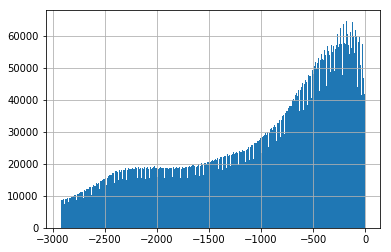

In [53]:
p = install_sorted['DAYS_INSTALMENT'].hist(bins = 500)
p.plot()